<a href="https://colab.research.google.com/github/Aaryadeep/LungCancer/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf # Import tensorflow as tf

# Import ImageDataGenerator from the correct location
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras import Sequential # Use tensorflow.keras for Sequential
from tensorflow.keras.utils import to_categorical# Import to_categorical from utils
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D # Import layers from tensorflow.keras.layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # Import callbacks from tensorflow.keras.callbacks
from tensorflow.keras import regularizers, optimizers # Import regularizers and optimizers from tensorflow.keras

from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet, efficientnet, mobilenet_v2
from tensorflow.keras import Model
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import os
import cv2


In [ ]:
tf.__version__

'2.17.1'

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory
mv: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/archive -d Data

Archive:  /content/drive/MyDrive/archive.zip
  inflating: Data/Data/test/adenocarcinoma/000108 (3).png  
  inflating: Data/Data/test/adenocarcinoma/000109 (2).png  
  inflating: Data/Data/test/adenocarcinoma/000109 (4).png  
  inflating: Data/Data/test/adenocarcinoma/000109 (5).png  
  inflating: Data/Data/test/adenocarcinoma/000112 (2).png  
  inflating: Data/Data/test/adenocarcinoma/000113 (7).png  
  inflating: Data/Data/test/adenocarcinoma/000114 (5).png  
  inflating: Data/Data/test/adenocarcinoma/000114.png  
  inflating: Data/Data/test/adenocarcinoma/000115 (4).png  
  inflating: Data/Data/test/adenocarcinoma/000115 (8).png  
  inflating: Data/Data/test/adenocarcinoma/000115.png  
  inflating: Data/Data/test/adenocarcinoma/000116 (5).png  
  inflating: Data/Data/test/adenocarcinoma/000116 (7).png  
  inflating: Data/Data/test/adenocarcinoma/000116 (9).png  
  inflating: Data/Data/test/adenocarcinoma/000117 (4).png  
  inflating: Data/Data/test/adenocarcinoma/000117 (8).png  
  i

In [ ]:
path = "/content/Data/Data/train"
for files in os.listdir(path):
    print(os.path.join(path,files))

/content/Data/Data/train/normal
/content/Data/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
/content/Data/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
/content/Data/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


In [ ]:
train_path = "/content/Data/Data/train"
valid_path = "/content/Data/Data/valid"
test_path = "/content/Data/Data/test"

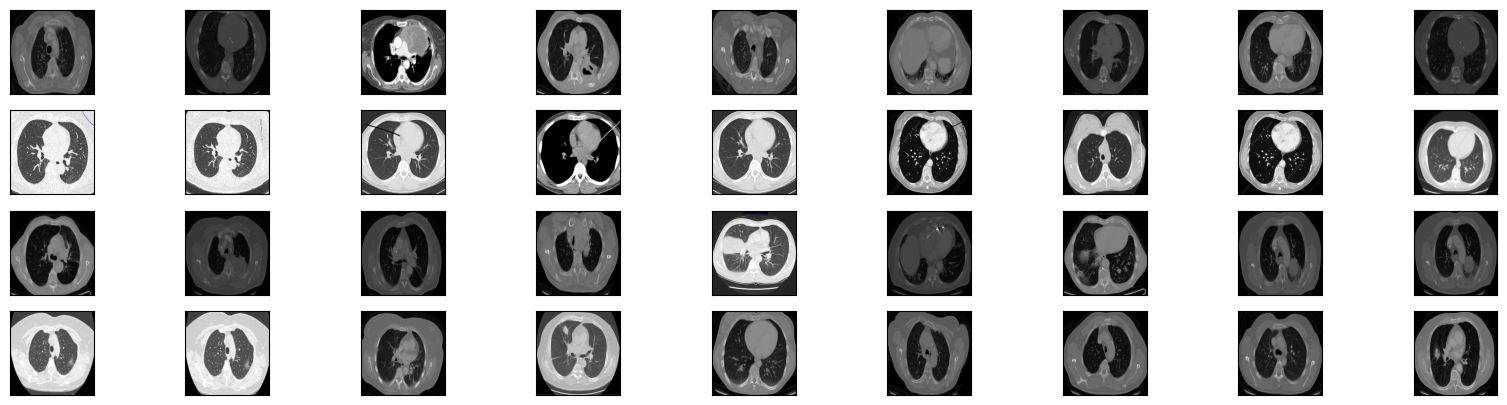

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def load_images(image_paths, n=36, target_size=(224, 224)): # Added target_size parameter
    """
    Loads images from the provided paths and resizes them to a uniform size.

    Args:
        image_paths (list): A list of paths to image folders.
        n (int): The total number of images to load (default: 36).
        target_size (tuple): The desired size (width, height) for the images (default: (224, 224)).

    Returns:
        numpy.ndarray: A NumPy array containing the loaded and resized images.
    """
    images = []
    for i in range(len(image_paths)):
        images_ = [cv2.imread(image_paths[i]+'/'+path) for path in os.listdir(image_paths[i])[:int(n/4)]]
        # Resize images to a uniform size
        images_ = [cv2.resize(img, target_size) for img in images_ if img is not None]
        images.append(images_)
    sample = np.asarray(images)
    return sample

image_paths = ['/content/Data/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa',
'/content/Data/Data/train/normal',
'/content/Data/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
'/content/Data/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']

sample = load_images(image_paths)
fig = plt.figure(figsize=(20,5))
l = 1
shapes = []
for i in range(sample.shape[0]):
    for m in range(sample.shape[1]):
        ax = fig.add_subplot(4,9,m+l,xticks = [], yticks = [])
        ax.imshow(np.squeeze(sample[i,m]))
        shapes.append(sample[i,m].shape)
    l +=9

In [ ]:
np.array(shapes).mean(axis=0)

array([224., 224.,   3.])

In [ ]:
image_shape = (224,224,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224, 224),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224, 224),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224, 224),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
base_hidden_units = 8
weight_decay = 1e-3
model = Sequential([

    Conv2D(filters = 8 , kernel_size = 2, padding = 'same', activation = 'relu', input_shape = image_shape),
    MaxPooling2D(pool_size = 2),

    Conv2D(filters = 16 , kernel_size = 2, padding = 'same', activation = 'relu',
           kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2),


    Dropout(0.4),
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(4,activation='softmax')

])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 8)         │             104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 16)        │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │      15,053,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,054,936 (57.43 MB)

 Trainable params: 15,054,936 (57.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam # Import Adam from tensorflow.keras.optimizers

checkpointer = ModelCheckpoint('chestmodel.keras',verbose=1, save_best_only= True) # Changed the file extension to .keras
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 15)
optimizer = Adam(learning_rate=0.001, decay=1e-6) # Now using the imported Adam


model.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
history = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - acc: 0.3278 - loss: 2.7367
Epoch 1: val_loss improved from inf to 1.11948, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - acc: 0.3323 - loss: 2.6558 - val_acc: 0.4722 - val_loss: 1.1195
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.11948
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.4722 - val_loss: 1.1195
Epoch 3/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.6563 - loss: 0.9719 
Epoch 3: val_loss improved from 1.11948 to 0.92674, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - acc: 0.6575 - loss: 0.9662 - val_acc: 0.5556 - val_loss: 0.9267
Epoch 4/100

Epoch 4: val_loss did not improve from 0.92674
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.5556 - val_loss: 0.9267
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - acc: 0.7372 - loss: 0.6781
Epoch 5: val_loss improved from 0.92674 to 0.80263, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - acc: 0.7387 - loss: 0.6754 - val_acc: 0.6806 - val_loss: 0.8026
Epoch 6/100

Epoch 6: val_loss improved from 0.80263 to 0.80263, saving model to chestmodel.keras
20/20 ━━━━━━━━━━━━

In [ ]:
result = model.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - acc: 0.4899 - loss: 2.2107


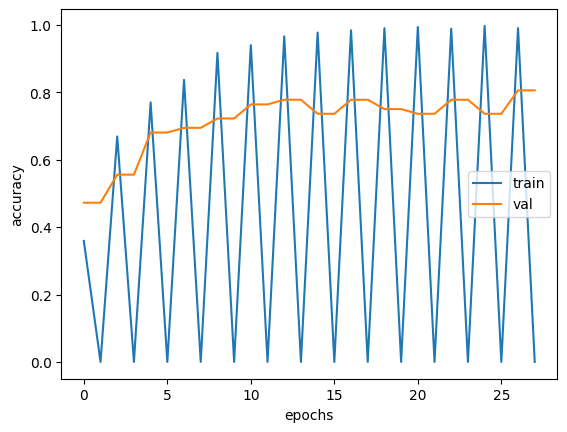

In [ ]:
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(dtype='float32', rescale=1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
vgg_model = VGG16(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in vgg_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,718,788 (56.15 MB)

 Trainable params: 3,076 (12.02 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [ ]:
optimizer = Adam(learning_rate=0.001, decay=1e-6)

model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-/vgg16.keras',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_vgg = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    batch_size = 16,
                    callbacks = [checkpointer, early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - acc: 0.2493 - loss: 1.5850
Epoch 1: val_loss improved from inf to 1.31624, saving model to ./chest_CT_SCAN-/vgg16.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - acc: 0.2548 - loss: 1.5740 - val_acc: 0.3194 - val_loss: 1.3162
Epoch 2/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.5552 - loss: 1.0115

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 1.31624 to 1.28258, saving model to ./chest_CT_SCAN-/vgg16.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.5566 - loss: 1.0097 - val_acc: 0.3194 - val_loss: 1.2826
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - acc: 0.5620 - loss: 0.9708
Epoch 3: val_loss improved from 1.28258 to 1.27231, saving model to ./chest_CT_SCAN-/vgg16.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 388ms/step - acc: 0.5637 - loss: 0.9693 - val_acc: 0.3194 - val_loss: 1.2723
Epoch 4/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - acc: 0.7007 - loss: 0.7979
Epoch 4: val_loss did not improve from 1.27231
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step - acc: 0.7011 - loss: 0.7978 - val_acc: 0.3194 - val_loss: 1.2832
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - acc: 0.6865 - loss: 0.8096
Epoch 5: val_loss did not improve from 1.27231
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 364ms/step - acc: 0.6864 - loss: 0.8086 - val_acc: 0.3194 - val_loss: 1.2801
Epoch 6/100
19/20 ━━━━━━━━━━━━━━━━━━━

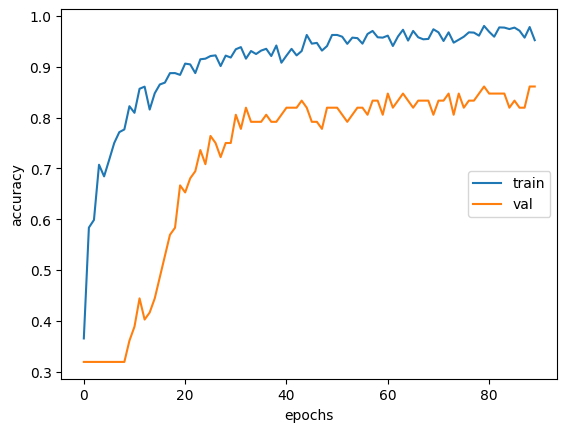

In [ ]:
plt.plot(history_vgg.history['acc'], label = 'train',)
plt.plot(history_vgg.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()


In [ ]:
result = model.evaluate(test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - acc: 0.8264 - loss: 0.4651
